In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import numba
from matplotlib.colors import LogNorm
import uproot_methods
import glob
from tqdm.auto import tqdm

import dask.dataframe as dd
from dask import delayed
from dask.distributed import Client
import dask.array as da

from utils import set_plotting_style, get_chunking_dask

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from functools import reduce

In [2]:
set_plotting_style()

In [3]:
# !pip install git+git://github.com/aminnj/yahist.git#egg=yahist -U
from yahist import Hist1D

## Make dataframe

In [4]:
def make_df(args):
    fname, entrystart, entrystop = args
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["pass_*",
                     "nDV","nMuon",
                     "BS_x","BS_y",
                     "/Muon_(pt|eta|phi|charge)$/",
                     "/DV_(rho.*|x|y)$/",
                    ],outputtype=dict,namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    
    # booleans for selection
    sel = (
        (arrs["nDV"] == 1) 
        & (arrs["nMuon"] == 2) 
        & arrs["pass_l1"] 
        & arrs["pass_skim"] 
#         & arrs["pass_fiducialgen"]
#         & (arrs["DV_rho"]>1.0).any()
    )

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]

    # augment
    TLVA = uproot_methods.TLorentzVectorArray
    TV2A = uproot_methods.TVector2Array
    mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],0.10566)
    mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],0.10566)
    dimu = mu1+mu2
    df["dimuon_mass"] = dimu.mass
    df["dimuon_eta"] = dimu.eta
    df["dimuon_phi"] = dimu.phi
    df["dimuon_pt"] = dimu.pt
    vecdimu = TV2A.from_polar(dimu.pt,dimu.phi)
    vecdv = TV2A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"])
    df["cosphi"] = vecdimu.cosdelta(vecdv)
    df["Muon1_m"] = 0.10566
    df["Muon2_m"] = 0.10566
    # pseudo proper decay time
    df["ctau"] = dimu.mass*(df["DV_rhoCorr"]*df["cosphi"])/(dimu.pt)
    
    # skim more
    df = df.query(
        "(Muon1_charge != Muon2_charge)"
#         " and (cosphi > 0.)"
#         " and (DV_xyErrorMax < 0.05)"
#         " and (DV_zError < 0.1)"
#         " and (Muon1_nValidMuonHits > 0)"
#         " and (Muon2_nValidMuonHits > 0)"
    )
    return df
    
# df_data = pd.concat(
#     map(make_df,glob.glob(
#         "/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_vtestskim1cm/*.root"
#     ))
# ).reset_index(drop=True)

delayed_make_df = delayed(make_df)

## Data jpsi fitting with dask

In [5]:
client = Client("uaf-10.t2.ucsd.edu:50123")
client

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 25 Cores: 25 Memory: 125.00 GB


In [6]:
fnames = tuple(sorted(glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_vtest/output_*.root")))
chunks, total_events = get_chunking_dask(fnames, 500e3, client=client)

In [7]:
meta = make_df((chunks[0][0],0,100))
dfdata = dd.from_delayed(map(delayed_make_df,chunks), meta=meta).persist()

In [8]:
len(dfdata)

36552262

In [9]:
counts, edges = client.compute(da.histogram(dfdata.query("2.8<dimuon_mass<3.2")["dimuon_pt"],bins=np.linspace(0,100,100)),sync=True)
h = Hist1D.from_bincounts(counts, edges, errors=counts**0.5)
h

[0.000 ± 0.000   0.000 ± 0.000   0.000 ± 0.000   0.000 ± 0.000
 0.000 ± 0.000   13142.000 ± 114.639   214389.000 ± 463.022
 691056.000 ± 831.298   1080680.000 ± 1039.558   1224788.000 ± 1106.701
 1199278.000 ± 1095.116   1074459.000 ± 1036.561   906476.000 ± 952.090
 741666.000 ± 861.200   600643.000 ± 775.012   482273.000 ± 694.459
 388684.000 ± 623.445   312517.000 ± 559.032   252493.000 ± 502.487
 207060.000 ± 455.038   167846.000 ± 409.690   138480.000 ± 372.129
 114401.000 ± 338.232   95487.000 ± 309.010   79481.000 ± 281.924
 67100.000 ± 259.037   56770.000 ± 238.265   48274.000 ± 219.713
 41271.000 ± 203.153   35166.000 ± 187.526   30506.000 ± 174.660
 26660.000 ± 163.279   22858.000 ± 151.189   19796.000 ± 140.698
 17293.000 ± 131.503   15115.000 ± 122.943   13383.000 ± 115.685
 11663.000 ± 107.995   10527.000 ± 102.601   9192.000 ± 95.875
 8218.000 ± 90.653   7184.000 ± 84.758   6255.000 ± 79.089
 5571.000 ± 74.639   5068.000 ± 71.190   4627.000 ± 68.022
 4093.000 ± 63.977   3754.000 ± 61.270   3331.000 ± 57.715
 2964.000 ± 54.443   2709.000 ± 52.048   2447.000 ± 49.467
 2227.000 ± 47.191   1938.000 ± 44.023   1714.000 ± 41.400
 1703.000 ± 41.267   1554.000 ± 39.421   1412.000 ± 37.577
 1262.000 ± 35.525   1108.000 ± 33.287   1077.000 ± 32.818
 963.000 ± 31.032   869.000 ± 29.479   825.000 ± 28.723   712.000 ± 26.683
 619.000 ± 24.880   616.000 ± 24.819   606.000 ± 24.617   573.000 ± 23.937
 493.000 ± 22.204   470.000 ± 21.679   427.000 ± 20.664   409.000 ± 20.224
 322.000 ± 17.944   357.000 ± 18.894   297.000 ± 17.234   295.000 ± 17.176
 297.000 ± 17.234   266.000 ± 16.310   291.000 ± 17.059   234.000 ± 15.297
 223.000 ± 14.933   188.000 ± 13.711   167.000 ± 12.923   171.000 ± 13.077
 149.000 ± 12.207   135.000 ± 11.619   138.000 ± 11.747   125.000 ± 11.180
 128.000 ± 11.314   122.000 ± 11.045   87.000 ± 9.327   95.000 ± 9.747
 111.000 ± 10.536   95.000 ± 9.747   94.000 ± 9.695   63.000 ± 7.937
 81.000 ± 9.000   53.000 ± 7.280]

In [10]:
rhoedges = [0,0.02,0.05,0.1,0.2,0.5,1.0,1.5,2.5,5.0]
lows, highs = rhoedges[:-1], rhoedges[1:]
d_counts = {}
for low,high in zip(lows,highs):
    counts, edges = da.histogram(
        dfdata.query("({}<DV_rhoCorr<{})".format(low,high))["dimuon_mass"],
#         dfdata.query("({}<DV_rhoCorr<{}) and 10<dimuon_pt<15".format(low,high))["dimuon_mass"],
        bins=np.linspace(1.8,6,301)
    )
    d_counts[(low,high)] = (counts, edges)
d_counts = client.compute(d_counts).result()
hists = {}
for (low,high),(counts,edges) in d_counts.items():
    hists[(low,high)] = Hist1D.from_bincounts(counts, edges, errors=counts**0.5)

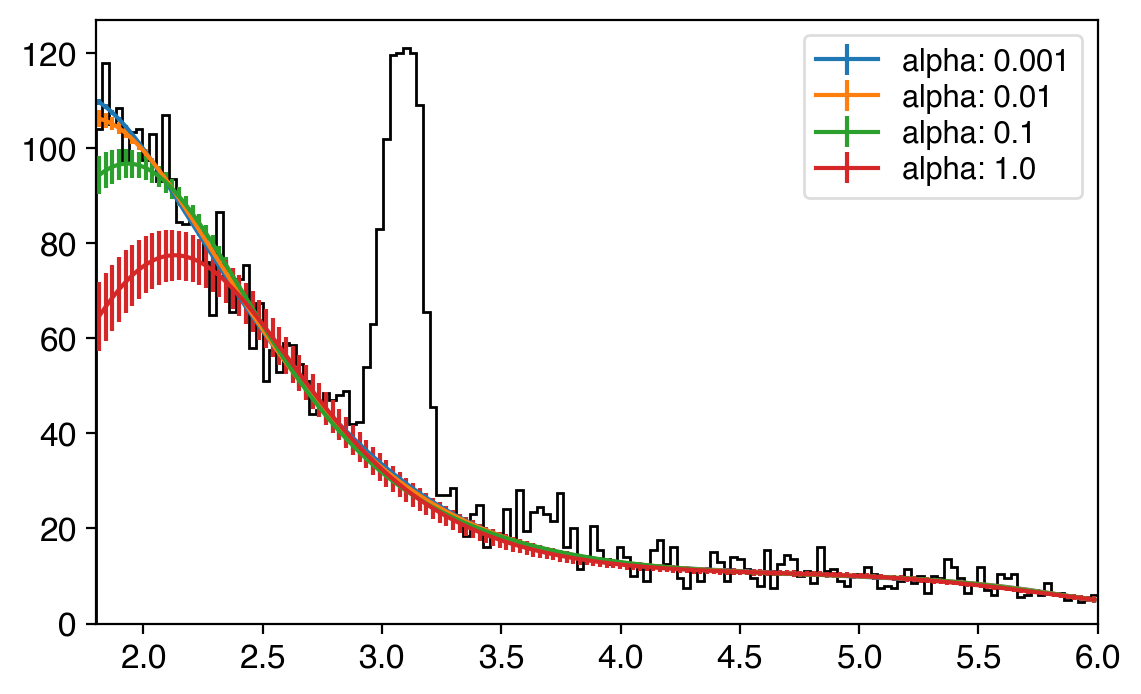

In [11]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

def get_preds(h,alpha=0.01, to_mask=[(2.8,3.3),(3.5,3.9)], c1=1.0, r1=1.0):
    xflat = h.bin_centers
    mask = ~reduce(np.logical_or,[((xflat>low) & (xflat<high)) for low,high in to_mask])
    do_log_transform = True
    X = xflat[mask][:,np.newaxis]
    y = h.counts[mask]
    if do_log_transform:
        y = np.log(y)
    dy = h.errors[mask]

    goodvals = np.isfinite(y)
    X = X[goodvals]
    y = y[goodvals]
    dy = dy[goodvals]

#     kernel = ConstantKernel(1, "fixed") * RBF(1., "fixed") # + WhiteKernel(noise_level=0.1, noise_level_bounds=(0.01,0.4))
#     kernel = ConstantKernel(c1, "fixed") * RBF(r1, "fixed") + WhiteKernel(noise_level=0.1, noise_level_bounds=(0.01,0.4))
    kernel = ConstantKernel(c1, "fixed") * RBF(r1, "fixed")
#     kernel = ConstantKernel(c1) * RBF(r1)
    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=alpha*dy/dy.max(),
    )

    gp.fit(X, y)

    ypred,sigma = gp.predict(h.bin_centers[:,np.newaxis], return_std=True)
#     print(gp.kernel_.get_params())
    sigma *= 1.95
    relerr = sigma/ypred
    if do_log_transform:
        ypred = np.exp(ypred)
    sigma = ypred*relerr
    return ypred, sigma

fig, ax = plt.subplots()

for alpha in [0.001,0.01,0.1,1.0]:
    h = hists[(2.5,5.0)].rebin(2)
    ypred, yerr = get_preds(h,alpha=alpha)
    ax.errorbar(h.bin_centers,ypred/2,yerr=yerr/2,label=f"alpha: {alpha}")
(h/2).plot(color="k",histtype="step")
_ = ax.legend()

Text(0, 0.5, 'Events per cm')

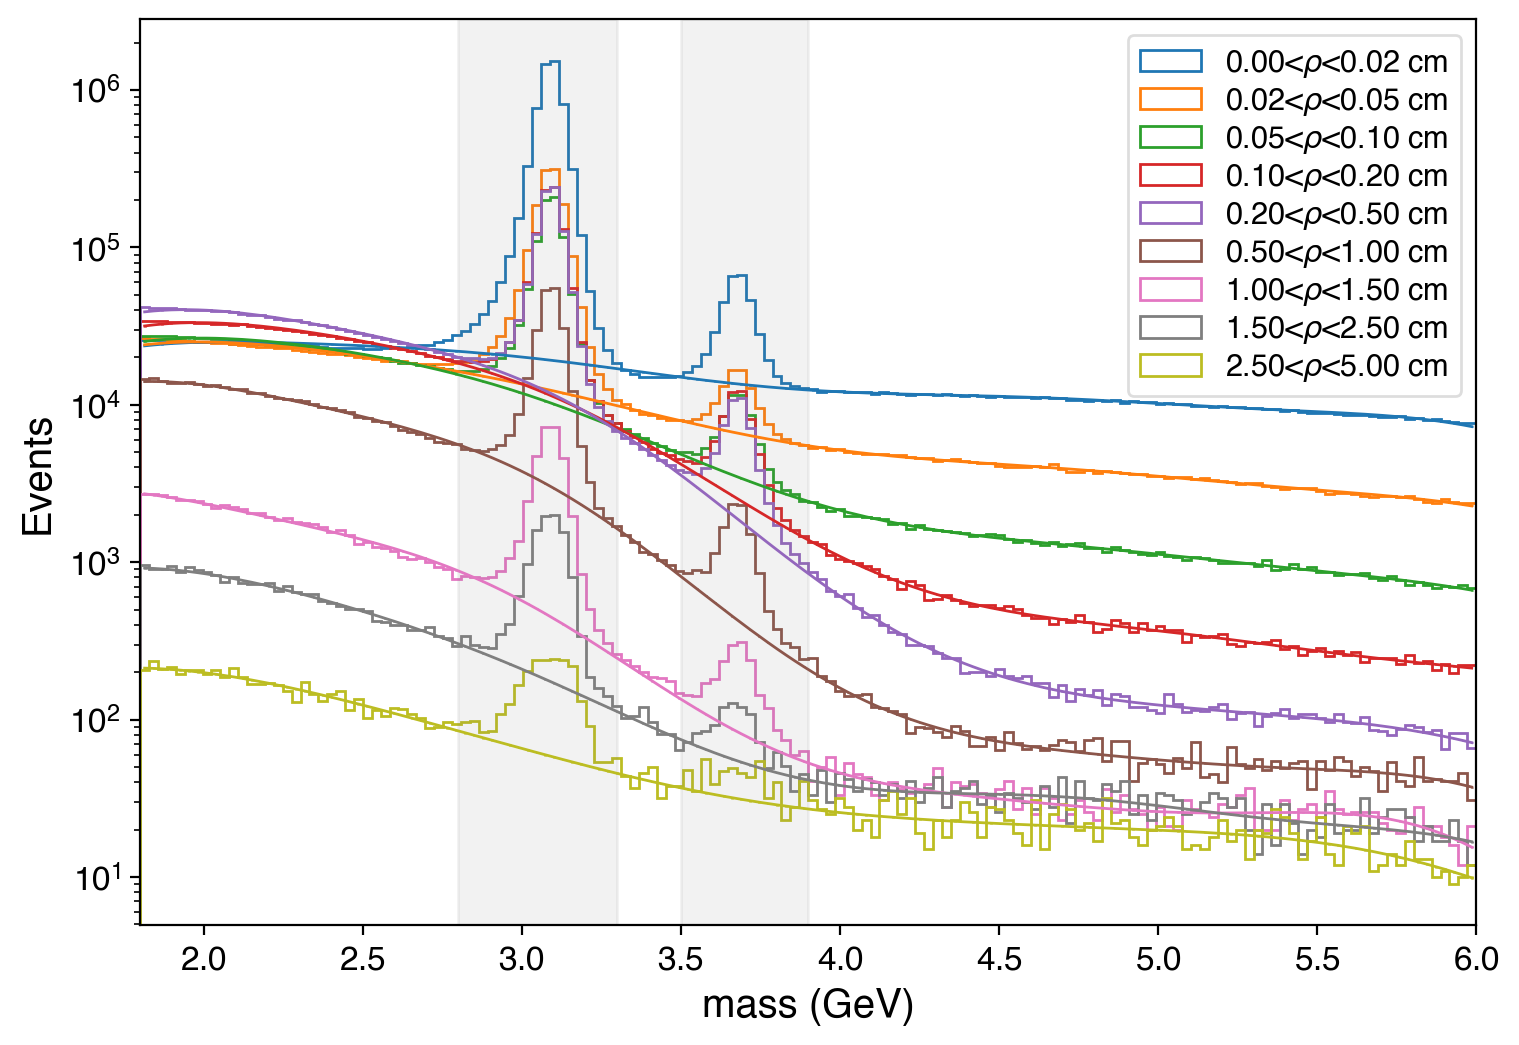

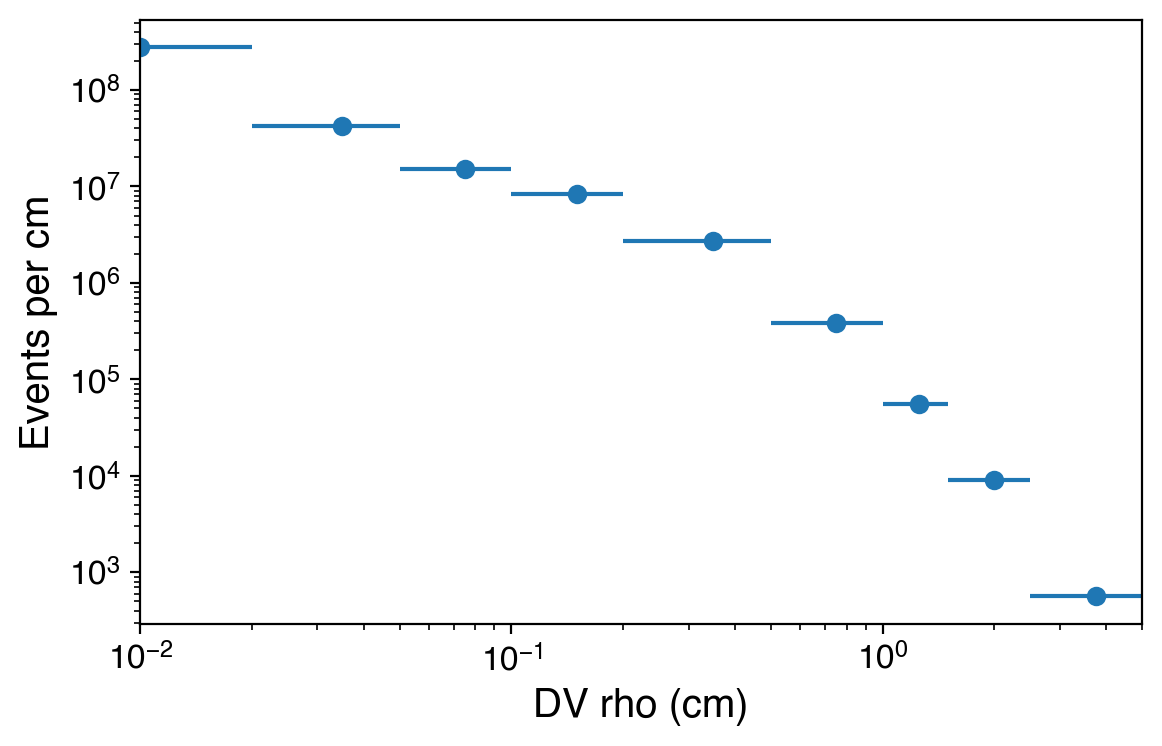

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
# fig, ax = plt.subplots(figsize=(8,2))
to_mask = [(2.8,3.3),(3.5,3.9)]
colors = (f"C{i}" for i in range(20))
# subtract_bg = True
subtract_bg = False
# ncolors = len(hists.values())*2
# colors = (plt.get_cmap('tab20',ncolors)(i) for i in range(ncolors))
data = []
for k,v in hists.items():
    c = next(colors)
    h = v.rebin(2)
    ypred,yprederr = get_preds(h,to_mask=to_mask)
    label = r"{:.2f}<$\rho$<{:.2f} cm".format(*k)
    if subtract_bg:
        ax.plot(h.bin_centers,h.counts-ypred,color=c,lw=1.0)
    else:
        h.plot(ax=ax,histtype="step",label=label,color=c)
#         ax.plot(h.bin_centers,ypred,color=c,lw=1.0)
        ax.errorbar(h.bin_centers,ypred,yerr=yprederr,color=c,lw=1.0)
    sel = (h.bin_centers > to_mask[0][0]) & (h.bin_centers < to_mask[0][1])
    data.append(dict(low=k[0],high=k[1],events=(h.counts[sel]-ypred[sel]).sum()))
if not subtract_bg:
    ax.set_yscale("log")
ax.legend()
for low,high in to_mask:
    ax.axvspan(low, high, alpha=0.1, color='gray')
ax.set_ylabel("Events")
_ = ax.set_xlabel("mass (GeV)");


tmp = pd.DataFrame(data).sort_values("low")
tmp["density"] = tmp.eval("events/(high-low)")
h = Hist1D.from_bincounts(tmp["density"].values,np.append(tmp["low"].values,tmp["high"].values[-1]))
h_jpsi_rho_data = h

fig, ax = plt.subplots()
h.plot(ax=ax,show_errors=True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("DV rho (cm)")
ax.set_ylabel("Events per cm")

## Jpsi MC with dask

In [13]:
def get_hist_mc(prompt=True):
    if prompt:
        fnames = tuple(sorted(glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/JpsiToMuMu_JpsiPt8_TuneCP5_13TeV-pythia8_RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1_AODSIM_v5//output_*.root")))
    else:
        fnames = tuple(sorted(glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/BuToKJpsi_ToMuMu_MuFilter_SoftQCDnonD_TuneCP5_13TeV-pythia8-evtgen_RunIIAutumn18DR-PUPoissonAve20_102X_upgrade2018_realistic_v15-v2_AODSIM_v6/output_*.root")))
    chunks, total_events = get_chunking_dask(fnames, 50e3, client=client)
    meta = make_df((chunks[0][0],0,100))
    dfmc = dd.from_delayed(map(delayed_make_df,chunks), meta=meta)
    
    bins = np.array(rhoedges)
    counts, edges = client.compute(da.histogram(dfmc.query("(2.8<dimuon_mass<3.2)")["DV_rhoCorr"],bins=bins),sync=True)

    # per cm
    counts = counts/edges[1:]-edges[:-1]
    h = Hist1D.from_bincounts(counts,edges)
    return h

In [14]:
h_jpsi_rho_mc_fromb = get_hist_mc(prompt=False)
h_jpsi_rho_mc_prompt = get_hist_mc(prompt=True)

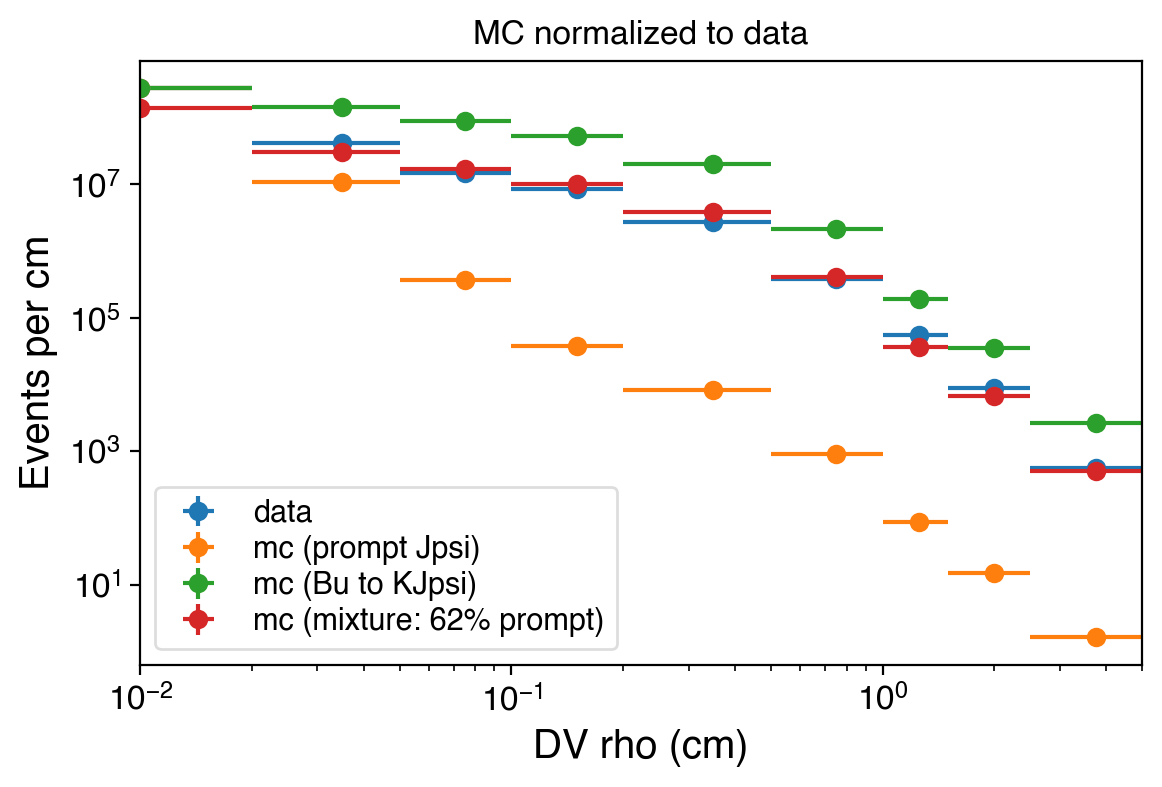

In [15]:
# https://arxiv.org/pdf/1011.4193.pdf @ 7TeV
# eq 12 and 13 indicates frac_prompt = 0.73
# not so bad!

# @interact(frac=(0.5,0.7,0.01))
# def f(frac=0.62):
fig, ax = plt.subplots()

h_jpsi_rho_data.plot(ax=ax,show_errors=True,label="data")

frac_prompt = 0.62
sf = (h_jpsi_rho_data.counts[0]/h_jpsi_rho_mc_prompt.counts[0])
(sf*h_jpsi_rho_mc_prompt).plot(ax=ax,show_errors=True,label="mc (prompt Jpsi)")
sf = (h_jpsi_rho_data.counts[0]/h_jpsi_rho_mc_fromb.counts[0])
(sf*h_jpsi_rho_mc_fromb).plot(ax=ax,show_errors=True,label="mc (Bu to KJpsi)")

sf1 = 0.5*h_jpsi_rho_data.counts[0]/h_jpsi_rho_mc_prompt.counts[0]
sf2 = 0.5*h_jpsi_rho_data.counts[0]/h_jpsi_rho_mc_fromb.counts[0]
(frac_prompt*sf1*h_jpsi_rho_mc_prompt+(1-frac_prompt)*sf2*h_jpsi_rho_mc_fromb).plot(
    ax=ax,show_errors=True,label="mc (mixture: {:.0f}% prompt)".format(frac_prompt*100.)
)


ax.set_title("MC normalized to data")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("DV rho (cm)")
ax.set_ylabel("Events per cm")
ax.legend()